In [1]:
%matplotlib inline

# Imports

In [2]:
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt

import glob

# Custom plotting parameters

In [3]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.8'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True

matplotlib.rcParams['legend.fontsize'] = 10


###The following is used to create some sensible results folders according to the year/month
import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

# Load in the clean `.tsv` file


In [76]:
df = pd.read_csv('../Data/host_genomes/562.clean.tsv', sep='\t', index_col=0)
df.head()

,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,upstream_sequence,RBS_energy,RBS_energy_upstream,iCUB,GC_cds,GC_upstream,locus_tag,secondary_structure
0,NC_000913.3,RefSeq,CDS,190,255,.,+,0,ID=cds-NP_414542.1;Parent=gene-b0001;Dbxref=Un...,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,CAGATAAAAATTACAGAGTACACAACATCC,-2.45,-2.46,32.046035,0.515152,0.333333,b0001,-1.56
1,NC_000913.3,RefSeq,CDS,337,2799,.,+,0,ID=cds-NP_414543.1;Parent=gene-b0002;Dbxref=Un...,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,TTTTCGACCAAAGGTAACGAGGTAACAACC,-5.42,-2.52,55.949262,0.530654,0.433333,b0002,-9.78
2,NC_000913.3,RefSeq,CDS,2801,3733,.,+,0,ID=cds-NP_414544.1;Parent=gene-b0003;Dbxref=Un...,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,GTACCCTCTCATGGAAGTTAGGAGTCTGAC,-6.51,-3.60,56.062386,0.562701,0.500000,b0003,-14.65
3,NC_000913.3,RefSeq,CDS,3734,5020,.,+,0,ID=cds-NP_414545.1;Parent=gene-b0004;Dbxref=Un...,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,ACGGCGGGCGCACGAGTACTGGAAAACTAA,-3.40,-2.54,53.052776,0.528361,0.566667,b0004,-4.86
4,NC_000913.3,RefSeq,CDS,5234,5530,.,+,0,ID=cds-NP_414546.1;Parent=gene-b0005;Dbxref=Un...,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,CATAACGGGCAATGATAAAAGGAGTAACCT,-6.51,-1.42,50.705530,0.538721,0.400000,b0005,-7.80


**Some later data will require the "Gene" merge so make it a dedicated column and filter any duplicates**

In [77]:
print(df.shape)
df['Gene'] = df['qualifiers'].str.split(';gene=', n=1, expand=True)[1]\
                                .str.split(';', n=1, expand=True)[0]
df = df.drop_duplicates('Gene', keep=False)
print(df.shape)

(4060, 18)
(4060, 19)


# Add in knowledge of protein abundances and join the dataframes


In [78]:
prot_df = pd.read_csv('../Data/562_associated_data/511145-WHOLE_ORGANISM-integrated.txt',\
                      sep='\t', comment='#', header=None)
print(prot_df.shape)
prot_df.head()

(4096, 3)


,0,1,2
0,6881590,511145.b0789,1.10
1,6882118,511145.b1341,25.20
2,6882232,511145.b1475,2.97
3,6883902,511145.b3309,2603.00
4,6881517,511145.b0708,1.45


**Add in a dedicated `locus_tag` column by splitting column 1**

In [79]:
prot_df['locus_tag']= prot_df[1].str.split(".", n = 1, expand = True)[1]
assert prot_df['locus_tag'].value_counts().max() == 1
prot_df.head()

,0,1,2,locus_tag
0,6881590,511145.b0789,1.10,b0789
1,6882118,511145.b1341,25.20,b1341
2,6882232,511145.b1475,2.97,b1475
3,6883902,511145.b3309,2603.00,b3309
4,6881517,511145.b0708,1.45,b0708


**Rename the columns and drop the unnecessary bits**

In [80]:
prot_df = prot_df.drop([0, 1], axis=1)
prot_df.columns = ['prot_abundance', 'locus_tag']
prot_df.head()

,prot_abundance,locus_tag
0,1.10,b0789
1,25.20,b1341
2,2.97,b1475
3,2603.00,b3309
4,1.45,b0708


**Merge with the original dataframe on `locus_tag`**

In [81]:
combined_df = df.merge(prot_df, on='locus_tag', how='left')
print(combined_df.shape)
combined_df.head()

(4060, 20)


,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,upstream_sequence,RBS_energy,RBS_energy_upstream,iCUB,GC_cds,GC_upstream,locus_tag,secondary_structure,Gene,prot_abundance
0,NC_000913.3,RefSeq,CDS,190,255,.,+,0,ID=cds-NP_414542.1;Parent=gene-b0001;Dbxref=Un...,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,CAGATAAAAATTACAGAGTACACAACATCC,-2.45,-2.46,32.046035,0.515152,0.333333,b0001,-1.56,thrL,0.0
1,NC_000913.3,RefSeq,CDS,337,2799,.,+,0,ID=cds-NP_414543.1;Parent=gene-b0002;Dbxref=Un...,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,TTTTCGACCAAAGGTAACGAGGTAACAACC,-5.42,-2.52,55.949262,0.530654,0.433333,b0002,-9.78,thrA,317.0
2,NC_000913.3,RefSeq,CDS,2801,3733,.,+,0,ID=cds-NP_414544.1;Parent=gene-b0003;Dbxref=Un...,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,GTACCCTCTCATGGAAGTTAGGAGTCTGAC,-6.51,-3.60,56.062386,0.562701,0.500000,b0003,-14.65,thrB,76.3
3,NC_000913.3,RefSeq,CDS,3734,5020,.,+,0,ID=cds-NP_414545.1;Parent=gene-b0004;Dbxref=Un...,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,ACGGCGGGCGCACGAGTACTGGAAAACTAA,-3.40,-2.54,53.052776,0.528361,0.566667,b0004,-4.86,thrC,530.0
4,NC_000913.3,RefSeq,CDS,5234,5530,.,+,0,ID=cds-NP_414546.1;Parent=gene-b0005;Dbxref=Un...,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,CATAACGGGCAATGATAAAAGGAGTAACCT,-6.51,-1.42,50.705530,0.538721,0.400000,b0005,-7.80,yaaX,0.0


**Not sure how 0.0 protein abundances make sense so let's change them to NaN**

In [82]:
print(combined_df[combined_df['prot_abundance']==0.0].shape)
combined_df.at[combined_df[combined_df['prot_abundance']==0.0].index, 'prot_abundance'] = np.nan
print(combined_df[combined_df['prot_abundance'].isnull()].shape)

(317, 20)
(484, 20)


# Add in knowledge from two essential gene sets

## First, using annotated essential genes from:
https://mbio.asm.org/content/9/1/e02096-17

In [83]:
essential_df = pd.read_csv('../Data/562_associated_data/ecoli_essential.txt', sep='\t')
print('All:', essential_df.shape)
print('Essential:', essential_df[essential_df['Essential'] == True].shape)
print('Non-essential:', essential_df[essential_df['Non-essential'] == True].shape)
print('Unclear:', essential_df[essential_df['Unclear'] == True].shape)
essential_df.head()

All: (4313, 6)
Essential: (358, 6)
Non-essential: (3793, 6)
Unclear: (162, 6)


,Gene,Insertion Index Score,Log Likelihood Ratio,Essential,Non-essential,Unclear
0,thrL,0.393939,31.431059,False,True,False
1,thrA,0.219245,17.200782,False,True,False
2,thrB,0.265809,21.234549,False,True,False
3,thrC,0.205905,15.994924,False,True,False
4,yaaX,0.225589,17.765507,False,True,False


In [84]:
essential_df['essentiality_ds1'] = ''
indices = essential_df[essential_df['Essential']==True].index
essential_df.loc[indices, 'essentiality_ds1'] = 'Essential'
indices = essential_df[essential_df['Non-essential']==True].index
essential_df.loc[indices, 'essentiality_ds1'] = 'Non-essential'
indices = essential_df[essential_df['Unclear']==True].index
essential_df.loc[indices, 'essentiality_ds1'] = 'Unclear'
essential_df.head()

,Gene,Insertion Index Score,Log Likelihood Ratio,Essential,Non-essential,Unclear,essentiality_ds1
0,thrL,0.393939,31.431059,False,True,False,Non-essential
1,thrA,0.219245,17.200782,False,True,False,Non-essential
2,thrB,0.265809,21.234549,False,True,False,Non-essential
3,thrC,0.205905,15.994924,False,True,False,Non-essential
4,yaaX,0.225589,17.765507,False,True,False,Non-essential


In [85]:
essential_df['essentiality_ds1'].value_counts()

Non-essential    3793
Essential         358
Unclear           162
Name: essentiality_ds1, dtype: int64

**Drop the unnecessary bits**

In [86]:
essential_df = essential_df.drop(set(essential_df.columns)-set(['Gene', 'essentiality_ds1']), axis=1)
essential_df.head()

,Gene,essentiality_ds1
0,thrL,Non-essential
1,thrA,Non-essential
2,thrB,Non-essential
3,thrC,Non-essential
4,yaaX,Non-essential


In [87]:
combined_df = combined_df.merge(essential_df, on="Gene", how='left')
print(combined_df.shape)
combined_df.head()

(4060, 21)


,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,...,RBS_energy,RBS_energy_upstream,iCUB,GC_cds,GC_upstream,locus_tag,secondary_structure,Gene,prot_abundance,essentiality_ds1
0,NC_000913.3,RefSeq,CDS,190,255,.,+,0,ID=cds-NP_414542.1;Parent=gene-b0001;Dbxref=Un...,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,...,-2.45,-2.46,32.046035,0.515152,0.333333,b0001,-1.56,thrL,NaN,Non-essential
1,NC_000913.3,RefSeq,CDS,337,2799,.,+,0,ID=cds-NP_414543.1;Parent=gene-b0002;Dbxref=Un...,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,...,-5.42,-2.52,55.949262,0.530654,0.433333,b0002,-9.78,thrA,317.0,Non-essential
2,NC_000913.3,RefSeq,CDS,2801,3733,.,+,0,ID=cds-NP_414544.1;Parent=gene-b0003;Dbxref=Un...,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,...,-6.51,-3.60,56.062386,0.562701,0.500000,b0003,-14.65,thrB,76.3,Non-essential
3,NC_000913.3,RefSeq,CDS,3734,5020,.,+,0,ID=cds-NP_414545.1;Parent=gene-b0004;Dbxref=Un...,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,...,-3.40,-2.54,53.052776,0.528361,0.566667,b0004,-4.86,thrC,530.0,Non-essential
4,NC_000913.3,RefSeq,CDS,5234,5530,.,+,0,ID=cds-NP_414546.1;Parent=gene-b0005;Dbxref=Un...,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,...,-6.51,-1.42,50.705530,0.538721,0.400000,b0005,-7.80,yaaX,NaN,Non-essential


## And from:
https://www.nature.com/articles/s41586-018-0124-0

In [88]:
essential_df = pd.read_csv('../Data/562_associated_data/ecoli_essential_Price.txt', sep='\t', skiprows=13)
print(essential_df.shape)
essential_df.head()

(324, 19)


,organism,orgId,locusId,sysName,locus_tag,protein_id,uniprotId,scaffoldId,begin,end,strand,name,desc,GC,nReads,normreads,nPosCentral,dens,geneClass
0,Escherichia coli BW25113,Keio,14168,b0023,BW25113_RS00110,WP_001274021.1,sp|P0A7U7|RS20_ECOLI,7023,20815,21078,-,rpsT,30S ribosomal protein S20 (NCBI),0.4659,0,0.000,0,0.0,Arole
1,Escherichia coli BW25113,Keio,14170,b0025,BW25113_RS00120,WP_000767329.1,sp|P0AG40|RIBF_ECOLI,7023,21407,22348,+,ribF,hypothetical protein (NCBI),0.5361,201,0.056,0,0.0,Arole
2,Escherichia coli BW25113,Keio,14171,b0026,BW25113_RS00125,WP_001286857.1,sp|P00956|SYI_ECOLI,7023,22391,25207,+,ileS,isoleucyl-tRNA synthetase (NCBI),0.5577,0,0.000,0,0.0,Arole
3,Escherichia coli BW25113,Keio,14172,b0027,BW25113_RS00130,WP_000083372.1,sp|P00804|LSPA_ECOLI,7023,25207,25701,+,lspA,signal peptidase II (NCBI),0.5354,0,0.000,0,0.0,Arole
4,Escherichia coli BW25113,Keio,14174,b0029,BW25113_RS00140,WP_001166395.1,sp|P62623|ISPH_ECOLI,7023,26277,27227,+,ispH,4-hydroxy-3-methylbut-2-enyl diphosphate reduc...,0.5510,0,0.000,0,0.0,Bspecific


**Drop the unnecessary bits**

In [89]:
essential_df['essentiality_ds2'] = 'Essential'
essential_df = essential_df.drop(set(essential_df.columns) - set(['sysName', 'essentiality_ds2']), axis=1)
essential_df.columns = ['locus_tag', 'essentiality_ds2']
essential_df.head()

,locus_tag,essentiality_ds2
0,b0023,Essential
1,b0025,Essential
2,b0026,Essential
3,b0027,Essential
4,b0029,Essential


**Merge with my now growing dataframe**

In [90]:
combined_df = combined_df.merge(essential_df, on='locus_tag', how='left')
print(combined_df.shape)
indices = combined_df[combined_df['essentiality_ds2']!='Essential'].index
combined_df.loc[indices, 'essentiality_ds2'] = 'Non-essential'
combined_df.head()

(4060, 22)


,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,...,RBS_energy_upstream,iCUB,GC_cds,GC_upstream,locus_tag,secondary_structure,Gene,prot_abundance,essentiality_ds1,essentiality_ds2
0,NC_000913.3,RefSeq,CDS,190,255,.,+,0,ID=cds-NP_414542.1;Parent=gene-b0001;Dbxref=Un...,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,...,-2.46,32.046035,0.515152,0.333333,b0001,-1.56,thrL,NaN,Non-essential,Non-essential
1,NC_000913.3,RefSeq,CDS,337,2799,.,+,0,ID=cds-NP_414543.1;Parent=gene-b0002;Dbxref=Un...,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,...,-2.52,55.949262,0.530654,0.433333,b0002,-9.78,thrA,317.0,Non-essential,Non-essential
2,NC_000913.3,RefSeq,CDS,2801,3733,.,+,0,ID=cds-NP_414544.1;Parent=gene-b0003;Dbxref=Un...,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,...,-3.60,56.062386,0.562701,0.500000,b0003,-14.65,thrB,76.3,Non-essential,Non-essential
3,NC_000913.3,RefSeq,CDS,3734,5020,.,+,0,ID=cds-NP_414545.1;Parent=gene-b0004;Dbxref=Un...,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,...,-2.54,53.052776,0.528361,0.566667,b0004,-4.86,thrC,530.0,Non-essential,Non-essential
4,NC_000913.3,RefSeq,CDS,5234,5530,.,+,0,ID=cds-NP_414546.1;Parent=gene-b0005;Dbxref=Un...,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,...,-1.42,50.705530,0.538721,0.400000,b0005,-7.80,yaaX,NaN,Non-essential,Non-essential


## Finally add a consensus column of gene essentiality

In [91]:
combined_df['essentiality'] = 'Unclear'
indices = combined_df[(combined_df['essentiality_ds1']=='Essential')&
                      (combined_df['essentiality_ds2']=='Essential')].index
combined_df.at[indices, 'essentiality'] = 'Essential'
indices = combined_df[(combined_df['essentiality_ds1']!='Essential')&
                      (combined_df['essentiality_ds2']!='Essential')].index
combined_df.at[indices, 'essentiality'] = 'Non-essential'

combined_df['essentiality'].value_counts()

Non-essential    3669
Essential         269
Unclear           122
Name: essentiality, dtype: int64

# Manuscript analysis


## Exploration of variables with E. coli

In [92]:
col_to_label_dict = {'RBS_energy': 'aSD binding energy (kcal/mol)',
                    'RBS_energy_upstream': 'Upstream aSD binding\nenergy (kcal/mol)',
                    'prot_abundance': 'Protein abundance',
                    'iCUB': 'iCUB',
                    'GC_upstream': 'Upstream GC content',
                    'secondary_structure': 'Secondary structure (kcal/mol)'}

**Scatter plots between numeric variables**

Spearman correlation: 0.13583324694192472 3.412454892935976e-16


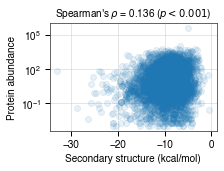

In [135]:
###TOGGLE ME
temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
# temp_df = combined_df
#
#
#
x_col = 'secondary_structure' ###CHANGE ME
x_label = col_to_label_dict[x_col]
#
y_col = 'prot_abundance' ###CHANGE ME
y_label = col_to_label_dict[y_col]
#
save_file = '/Ecoli_{}_v_{}.png'.format(x_col, y_col) ###Include beginning slash 
#
#
#
rho, p = stats.spearmanr(temp_df[x_col], temp_df[y_col])
fig, ax = plt.subplots(figsize=(3, 2))
if y_col in ['prot_abundance']:
    ax.semilogy(temp_df[x_col], temp_df[y_col], 'o', alpha=0.1)
else:
    ax.plot(temp_df[x_col], temp_df[y_col], 'o', alpha=0.1)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
if p < 10e-4:
    ax.set_title(r"Spearman's $\rho$ = {:.3f} ($p<0.001$)".format(rho))
else:
    ax.set_title(r"Spearman's $\rho$ = {:.3f} ($p={:.3f}$)".format(rho,p))
plt.savefig(figs_dir+save_file, dpi=300, bbox_inches='tight')

print('Spearman correlation:', rho, p)

**Boxplots for gene essentiality**

Kruskal-Wallis: 0.21796871073152824 0.8967444466273654


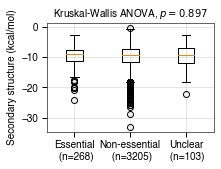

In [136]:
# temp_df = combined_df
temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
#
y_col = 'secondary_structure'
y_label = col_to_label_dict[y_col]
#
save_file = '/Ecoli_essential_v_{}.png'.format(y_col) ###Include beginning slash 


cats = ['Essential', 'Non-essential', 'Unclear']
cat_labels = []
box_data = []
for cat in cats:
    tempy = temp_df[temp_df['essentiality']==cat][y_col]
    box_data.append(tempy)
    cat_labels.append(cat + '\n (n={})'.format(tempy.shape[0]))
fig, ax = plt.subplots(figsize=(3,2))
ax.boxplot(box_data);
ax.set_xticklabels(cat_labels)
ax.set_ylabel(y_label)
if y_col == 'prot_abundance':
    ax.set_yscale('log')
#
stat, p = stats.kruskal(*box_data)
if p < 10e-4:
    ax.set_title(r"Kruskal-Wallis ANOVA, $p<0.001$".format(p))
else:
    ax.set_title(r"Kruskal-Wallis ANOVA, $p={:.3f}$".format(p))
    
plt.savefig(figs_dir+save_file, dpi=300, bbox_inches='tight')
print('Kruskal-Wallis:', stat, p)


## Example host-phage analysis

**Note that T7 id in this database is: 7841 and I'm using the predicted annotations here**

In [137]:
virus_df = pd.read_csv('../Data/562_rep_viruses/7841.clean.tsv', sep='\t', index_col=0)
print(virus_df.shape)
virus_df.head()

(49, 18)


,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,upstream_sequence,RBS_energy,RBS_energy_upstream,iCUB,GC_cds,GC_upstream,viral_id,secondary_structure
0,NC_001604|10760,Prodigal_v2.6.3,CDS,925,1278,64.7,+,0,ID=347_1;partial=00;start_type=ATG;rbs_motif=G...,ATGGCTATGTCTAACATGACTTACAACAACGTTTTCGACCACGCTT...,TTCACTAATAACTGCACGAGGTAACACAAG,-5.42,-0.34,50.525906,0.468927,0.400000,347_1,-5.17
1,NC_001604|10760,Prodigal_v2.6.3,CDS,1278,1433,17.1,+,0,ID=347_2;partial=00;start_type=ATG;rbs_motif=A...,ATGTCTACTACCAACGTGCAATACGGTCTGACCGCTCAAACTGTAC...,AGTCGAGGAGTACGAGGAGGATGAAGAGTA,-9.31,-6.36,43.066882,0.455128,0.500000,347_2,-10.17
2,NC_001604|10760,Prodigal_v2.6.3,CDS,1496,1639,13.3,+,0,ID=347_3;partial=00;start_type=ATG;rbs_motif=G...,ATGTATATGCTTACTATCGGTCTACTCACCGCTCTAGGTCTAGCTG...,TATGATTATCACTTTACTTATGAGGGAGTA,-5.82,-0.00,39.155014,0.458333,0.300000,347_3,-8.15
3,NC_001604|10760,Prodigal_v2.6.3,CDS,1636,1797,8.1,+,0,ID=347_4;partial=00;start_type=ATG;rbs_motif=G...,ATGATGAAGCACTACGTTATGCCAATCCACACGTCCAACGGGGCAA...,CATAGGAATCATCAAAGGGGCACTACGCAA,-5.53,-3.45,42.406008,0.481481,0.466667,347_4,-10.08
4,NC_001604|10760,Prodigal_v2.6.3,CDS,2021,3100,118.8,+,0,ID=347_5;partial=00;start_type=ATG;rbs_motif=A...,ATGAACATTACCGACATCATGAACGCTATCGACGCAATCAAAGCAC...,TCTCATAACGAACATAAAGGACACAATGCA,-4.00,-0.51,55.711182,0.493519,0.366667,347_5,-2.19


**Statistical differences in single variables between virus and host with a few different ways to slice host genes. Using ranksums to be conservative on significance.**

In [138]:
col_name = 'secondary_structure'
#
temp_df = combined_df
print('All data:', stats.ranksums(virus_df[col_name], temp_df[col_name]))
print('Means (virus, host):', np.mean(virus_df[col_name]), np.mean(temp_df[col_name]))
print()
#
temp_df = combined_df[combined_df['essentiality']=='Essential']
print('Essential dataset:', stats.ranksums(virus_df[col_name], temp_df[col_name]))
print('Means (virus, host):', np.mean(virus_df[col_name]), np.mean(temp_df[col_name]))
print()
#
temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
percentile_val = np.percentile(temp_df['prot_abundance'], 50)
temp_df = temp_df[temp_df['prot_abundance']>=percentile_val]
print('Top 50 protein abundance:', stats.ranksums(virus_df[col_name], temp_df[col_name]))
print('Means (virus, host):', np.mean(virus_df[col_name]), np.mean(temp_df[col_name]))
print()
#
temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
percentile_val = np.percentile(temp_df['prot_abundance'], 75)
temp_df = temp_df[temp_df['prot_abundance']>=percentile_val]
print('Top 25 protein abundance:', stats.ranksums(virus_df[col_name], temp_df[col_name]))
print('Means (virus, host):', np.mean(virus_df[col_name]), np.mean(temp_df[col_name]))
print()

All data: RanksumsResult(statistic=1.4839764785842922, pvalue=0.13781516077344036)
Means (virus, host): -8.923877551020407 -9.784268472906422

Essential dataset: RanksumsResult(statistic=1.0718961916365881, pvalue=0.2837666609607422)
Means (virus, host): -8.923877551020407 -9.568438661710044

Top 50 protein abundance: RanksumsResult(statistic=0.47935866680703954, pvalue=0.63168349282386)
Means (virus, host): -8.923877551020407 -9.196733780760624

Top 25 protein abundance: RanksumsResult(statistic=-0.25075956730714016, pvalue=0.8020000035379404)
Means (virus, host): -8.923877551020407 -8.782337807606266



**Visualize**

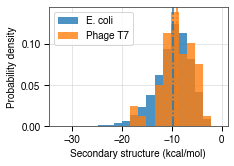

In [139]:
a, b = np.histogram(np.concatenate((combined_df[col_name].values, virus_df[col_name].values)), 20)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots(figsize=(3.2,2.2))
ax.hist(combined_df[col_name], bins=b, label='E. coli', density=True, alpha=0.8)
ax.hist(virus_df[col_name], bins=b, label='Phage T7', density=True, alpha=0.8)
ax.axvline(combined_df[col_name].mean(), color=colors[0], linestyle='-.')
ax.axvline(virus_df[col_name].mean(), color=colors[1], linestyle='-.')
ax.set_xlabel(col_to_label_dict[col_name])
ax.set_ylabel('Probability density')
plt.legend()
plt.savefig(figs_dir + '/Ecoli_T7_{}.png'.format(col_name), dpi=300, bbox_inches='tight')

# Comparing different categories of E. coli genes

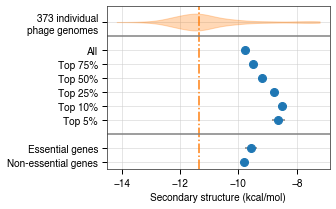

In [140]:
col_name = 'secondary_structure'


mean_virus = []
for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    mean_virus.append(virus_df[col_name].mean())

#All E. coli
host_means = [combined_df[col_name].mean()]
host_errs = [combined_df[col_name].std()/np.sqrt(combined_df.shape[0])]
#Restrict by protein abundance
temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
percentiles_to_test = [25, 50, 75, 90, 95]
#
#
all_y_vals = list(np.arange(0, -(len(percentiles_to_test)+1)/2, -0.5))
highest = all_y_vals[-1]
all_y_vals = all_y_vals + list(np.arange(highest-1.0, highest-2.0, -0.5))
#
#
for i in percentiles_to_test:
    percentile_thresh = np.percentile(temp_df['prot_abundance'], i)
    host_means.append(temp_df[temp_df['prot_abundance']>=percentile_thresh][col_name].mean())
    host_errs.append(temp_df[temp_df['prot_abundance']>=percentile_thresh][col_name].std()/
                    np.sqrt(temp_df[temp_df['prot_abundance']>=percentile_thresh].shape[0]))
#Restrict by essentiality
temp_df = combined_df[(combined_df['essentiality']=='Essential')]
host_means.append(temp_df[col_name].mean())
host_errs.append(temp_df[col_name].std()/\
                        np.sqrt(temp_df.shape[0]))
#
temp_df = combined_df[(combined_df['essentiality']=='Non-essential')]
host_means.append(temp_df[col_name].mean())
host_errs.append(temp_df[col_name].std()/\
                        np.sqrt(temp_df.shape[0]))
#
#
#
###Plot
fig, ax = plt.subplots(figsize=(4,3))
vparts = ax.violinplot([mean_virus], widths=0.6, vert=False, showextrema=False, points=100)
for pc in vparts['bodies']:
    pc.set_facecolor(colors[1])
    pc.set_edgecolor(colors[1])
ax.axvline(np.median(mean_virus), c=colors[1], linestyle='-.')
ax.axhline(0.5, c='gray')
#
ax.errorbar(host_means, all_y_vals, xerr=host_errs,\
            marker='o', linestyle='', mfc=colors[0], mec=colors[0], ecolor='gray',\
            zorder=1, markersize=8)
ax.axhline(-3, c='gray')
ax.set_xlabel(col_to_label_dict[col_name])
ax.set_yticks([1]+all_y_vals)
ax.set_yticklabels(['373 individual\nphage genomes',\
                    'All',\
                    'Top 75%',\
                    'Top 50%',\
                    'Top 25%',\
                    'Top 10%',\
                    'Top 5%',\
                    'Essential genes',\
                    'Non-essential genes']);
# plt.savefig(figs_dir + '/Ecoli_robust.png', dpi=300, bbox_inches='tight')

**Basic numbers / statistics for each of those comparisons above**

In [142]:
col_name = 'secondary_structure'
temp_df = combined_df
#
#
#
###Protein abundance stratification
# percent = 40
# temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
# percentile_val = np.percentile(temp_df['prot_abundance'], percent)
# temp_df = temp_df[temp_df['prot_abundance']>=percentile_val]
#
#
#
###Essentiality stratification
# temp_df = combined_df[(combined_df['essentiality']=='Essential')]
# temp_df = combined_df[(combined_df['essentiality']=='Non-essential')]
#
#
#
mean_host = temp_df[col_name].mean()
mean_virus = []
stat_vals = []
pvals = []
for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
#     statval, pval = stats.ttest_ind(virus_df[col_name], temp_df[col_name])
    statval, pval = stats.ranksums(virus_df[col_name], temp_df[col_name])
    stat_vals.append(statval)
    pvals.append(pval)
    mean_virus.append(virus_df[col_name].mean())
    
print('All (virus less, host less):', '\t\t', len([i for i in mean_virus if i < mean_host]),\
      len([i for i in mean_virus if i >= mean_host]))

zippy = list(zip(mean_virus, pvals))
print('Significant (virus less, host less):', '\t', len([i for i,j in zippy if i < mean_host and j < 0.01]),\
      len([i for i,j in zippy if i >= mean_host and j < 0.01]))

All (virus less, host less): 		 331 42
Significant (virus less, host less): 	 226 24


# Significance using a stricter set of independent viruses

In [ ]:
independent_set = []
with open('../Data/independent_set.txt', 'r') as infile:
    for line in infile:
        independent_set.append(line.split('/')[-1].split('.fasta')[0])
print(independent_set[:5])

In [ ]:
mean_virus = []
for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
    if virus_tsv.split('/')[-1].split('.clean.tsv')[0] not in independent_set:
        continue
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    mean_virus.append(virus_df[col_name].mean())

###Plot
fig, ax = plt.subplots(figsize=(4,3))
vparts = ax.violinplot([mean_virus], widths=0.6, vert=False, showextrema=False, points=100)
for pc in vparts['bodies']:
    pc.set_facecolor(colors[1])
    pc.set_edgecolor(colors[1])
ax.axvline(np.median(mean_virus), c=colors[1], linestyle='-.')
ax.axhline(0.5, c='gray')
ax.errorbar(host_means, np.arange(0, -len(host_means)/2, -0.5), xerr=host_errs,\
            marker='o', linestyle='', mfc=colors[0], mec=colors[0], ecolor='gray', zorder=1, markersize=8)
ax.axhline(-3, c='gray')
ax.errorbar(essentiality_means, np.arange(-3.5, -4.5, -0.5), xerr=essentiality_errs,\
            marker='o', linestyle='', mfc=colors[0], mec=colors[0], ecolor='gray', zorder=1, markersize=8)
ax.set_xlabel('Mean RBS energy (kcal/mol)')
ax.set_yticks([1]+list(np.arange(0, -len(host_means)/2, -0.5)) + [-3.5, -4.])
ax.set_yticklabels(['373 individual\nphage genomes',\
                    'All',\
                    'Top 75%',\
                    'Top 50%',\
                    'Top 25%',\
                    'Top 10%',\
                    'Top 5%',\
                    'Essential genes',\
                    'Non-essential genes']);
plt.savefig(figs_dir + '/Ecoli_robust_independent.png', dpi=300, bbox_inches='tight')

In [ ]:
col_name = 'RBS_energy'
#
# temp_df = combined_df
#
percent = 95
temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
temp_df = temp_df[temp_df['prot_abundance'] > 0]
percentile_val = np.percentile(temp_df['prot_abundance'], percent)
temp_df = temp_df[temp_df['prot_abundance']>=percentile_val]
#
# temp_df = combined_df[(combined_df['essentiality_a']!='Essential') &\
#                                      (combined_df['essentiality_b']!='Essential')]
mean_host = temp_df[col_name].mean()
#
mean_virus = []
stat_vals = []
pvals = []
for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
    if virus_tsv.split('/')[-1].split('.clean.tsv')[0] not in independent_set:
        continue
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
    statval, pval = stats.ranksums(virus_df[col_name], temp_df[col_name])
    stat_vals.append(statval)
    pvals.append(pval)
    mean_virus.append(virus_df[col_name].mean())
    
print('All:', len([i for i in mean_virus if i < mean_host]),\
      len([i for i in mean_virus if i >= mean_host]))

zippy = list(zip(mean_virus, pvals))
print('Significant:', len([i for i,j in zippy if i < mean_host and j < 0.01]),\
      len([i for i,j in zippy if i >= mean_host and j < 0.01]))

# Separating phages according to predicted lifestyle

In [ ]:
lifestyle_df = pd.read_csv('../Data/lifestyle_results_562.tsv', sep='\t', index_col=1)
lifestyle_df = lifestyle_df.drop('Unnamed: 0', axis=1)
lifestyle_df.head()

In [ ]:
col_name = 'RBS_energy'
mean_lytic = []
mean_temperate = []
for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
    vir_name = virus_tsv.split('/')[-1].split('.clean.tsv')[0]
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
#     if lifestyle_df.loc[int(vir_name)][1] < 0.6:
#         continue
#     if vir_name not in independent_set:
#         continue

    if lifestyle_df.loc[int(vir_name)][0] == 'Temperate': 
        mean_temperate.append(virus_df[col_name].mean())
    elif lifestyle_df.loc[int(vir_name)][0] == 'Lytic': 
        mean_lytic.append(virus_df[col_name].mean())
    else:
        print('Uhho')


print(len(mean_lytic), len(mean_temperate), len(mean_lytic + mean_temperate))

In [ ]:
trash, bins = np.histogram(np.concatenate((mean_lytic, mean_temperate)), 20)
fig, ax = plt.subplots(figsize=(4, 2.75))
ax.hist(mean_lytic, bins=bins, density=True, alpha=0.8, color=colors[2], label='Lytic')
ax.hist(mean_temperate, bins=bins, density=True, alpha=0.8, color=colors[4], label='Temperate')
ax.axvline(combined_df[col_name].mean())
plt.legend()
ax.set_xlabel('Mean RBS energy (kcal/mol)')
ax.set_ylabel('Probability density')
# plt.savefig(figs_dir + '/Ecoli_phage_lifestyle.png', dpi=300, bbox_inches='tight')

In [ ]:
print(stats.ttest_ind(mean_lytic, mean_temperate))
print(stats.ranksums(mean_lytic, mean_temperate))

# Statistics accounting for various factors

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
metric = 'RBS_energy'

results_list = []
host_df = pd.read_csv('../Data/host_genomes/562.clean.tsv', sep='\t', index_col=0)
host_name = host_df['genome_id'].value_counts().keys()[0]

for virus_tsv in glob.glob('../Data/562_rep_viruses/*.clean.tsv')[:]:
#     if virus_tsv.split('/')[-1].split('.clean.tsv')[0] not in independent_set:
#         continue
    virus_df = pd.read_csv(virus_tsv, sep='\t', index_col=0)
#     if virus_df.shape[0] < 50 or virus_df.shape[0] > 200:
#         continue
    #
    results_ind = []
    results_ind.append(virus_tsv)
    #
    ttest_res = stats.ttest_ind(host_df[metric], virus_df[metric])
    results_ind.append(ttest_res[0])
    results_ind.append(ttest_res[1])
    #
    ranksums_res = stats.ranksums(host_df[metric], virus_df[metric])
    results_ind.append(ranksums_res[0])
    results_ind.append(ranksums_res[1])
    #
    concat_df = pd.concat((host_df, virus_df), ignore_index=True, sort=False)
    concat_df['binary_predictor'] = 1
    concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0 
    #
    fitted = smf.logit('binary_predictor ~ {}'.format(metric), data=concat_df).fit()
    results_ind.append(fitted.params[metric])
    results_ind.append(fitted.pvalues[metric])
    #
    fitted = smf.logit('binary_predictor ~ {} + iCUB + GC_upstream'.format(metric), data=concat_df).fit()
    results_ind.append(fitted.params[metric])
    results_ind.append(fitted.pvalues[metric])
    
    results_list.append(results_ind)

In [ ]:
results_df = pd.DataFrame(results_list)
results_df.columns = ['virus', 'ttest_stat', 'ttest_p',\
                     'ranksums_stat', 'ranksums_p',\
                     'logistic_coef', 'logistic_p',\
                     'logistic_full_coef', 'logistic_full_p']
results_df.set_index(results_df['virus'], inplace=True)
results_df = results_df.drop('virus', axis=1)
print(results_df.shape)
results_df.head()

In [ ]:
trash, bins = np.histogram(np.concatenate((results_df['logistic_coef'], results_df['logistic_full_coef'])))
fig, ax = plt.subplots()
ax.hist(results_df['logistic_coef'], bins=bins, alpha=0.5)
ax.hist(results_df['logistic_full_coef'], bins=bins, alpha=0.5)

In [ ]:
print('Total significant, virus stronger, host stronger:',\
      results_df[(results_df['logistic_p']<0.01)].shape[0],\
      results_df[(results_df['logistic_p']<0.01) & (results_df['logistic_coef']<0.)].shape[0],\
      results_df[(results_df['logistic_p']<0.01) & (results_df['logistic_coef']>=0.)].shape[0])

In [ ]:
print('Total significant, virus stronger, host stronger:',\
      results_df[(results_df['logistic_full_p']<0.01)].shape[0],\
      results_df[(results_df['logistic_full_p']<0.01) & (results_df['logistic_full_coef']<0.)].shape[0],\
      results_df[(results_df['logistic_full_p']<0.01) & (results_df['logistic_full_coef']>=0.)].shape[0])

In [ ]:
fig, ax = plt.subplots(figsize=(3,2))
ax.semilogy(results_df['logistic_coef'], results_df['logistic_p'], marker='o', linestyle='', alpha=0.5)
ax.axvline(0.0, c='k')
ax.axhline(0.01, c='r', linestyle='--')
ax.set_xlabel('Logistic regression coefficient')
ax.set_ylabel('$p$-value')
ax.set_xlim(-1.1, 0.4)
ax.set_xticks([-0.8, -0.4, 0, 0.4])
ax.set_ylim(10e-35, 100)

fig, ax = plt.subplots(figsize=(3,2))
ax.semilogy(results_df['logistic_full_coef'], results_df['logistic_full_p'], marker='o', linestyle='', alpha=0.5)
ax.axvline(0.0, c='k')
ax.axhline(0.01, c='r', linestyle='--')
ax.set_xlabel('Logistic regression coefficient')
ax.set_ylabel('$p$-value')
ax.set_xlim(-1.1, 0.4)
ax.set_xticks([-0.8, -0.4, 0, 0.4])
ax.set_ylim(10e-35, 100)




In [99]:
import statsmodels.formula.api as smf

In [128]:
temp_df = combined_df[combined_df['prot_abundance'].isnull()==False]
fitted = smf.ols('np.log(prot_abundance) ~ RBS_energy', data=temp_df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     np.log(prot_abundance)   R-squared:                       0.009
Model:                                OLS   Adj. R-squared:                  0.008
Method:                     Least Squares   F-statistic:                     31.25
Date:                    Mon, 02 Mar 2020   Prob (F-statistic):           2.43e-08
Time:                            14:50:01   Log-Likelihood:                -9301.7
No. Observations:                    3576   AIC:                         1.861e+04
Df Residuals:                        3574   BIC:                         1.862e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1590      0.131      8.831      0.000       0.902       1.416
RBS_energy    -0.1385      0.025     -5.590      0.000      -0.187      -0.090
==============================================================================
Omnibus:                      113.489   Durbin-Watson:                   1.408
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.457
Skew:                          -0.363   Prob(JB):                     3.42e-23
Kurtosis:                       2.593   Cond. No.                         13.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:
temp_a = fitted.predict(combined_df)
temp_b = fitted.predict(virus_df)

In [130]:
stats.ranksums(temp_a, temp_b), np.mean(temp_a), np.mean(temp_b)

(RanksumsResult(statistic=-8.10720355307069, pvalue=5.179804609502637e-16),
 1.8189221549592878,
 2.2008082732118175)

In [132]:
stats.ranksums(virus_df['RBS_energy'], temp_df['RBS_energy'])

RanksumsResult(statistic=-8.027668674291865, pvalue=9.934233418434532e-16)

In [133]:
stats.ranksums(virus_df['secondary_structure'], temp_df['secondary_structure'])

RanksumsResult(statistic=1.342273807916194, pvalue=0.17950723267175228)